# Introduction

Dear viewers, welcome! <br>
We are **Ben Arviv** and **Daniel Dubinskey**, computer science students from the **Open University of Israel**, learning towards the fields of *Data Science* and *Machine Learning*. <br>
In the *Data Science Workshop* (20936) we learned many tools and techniques for data analysis and machine learning, and for our final project we chose to focus on the field of *Computer Vision* and *Deep Learning*. As a result, we decided to perform a data science project on a dataset we found on Kaggle, which is called **Brain Tumor Detection**. <br>
The main goal of the project is to contribute to the early detection and diagnosis of brain tumors, which aims to provide valuable support to **medical professionals** in creating effective treatment plans. The dataset consists of brain scans and has a diverse range of brain tumor images that are annotated to highlight the tumor regions.

## The Problem

Brain tumor detection presents multifaceted challenges stemming from the complexity and heterogeneity of brain tumors, coupled with the limitations of current diagnostic techniques. Early detection is hindered by the nonspecific nature of symptoms in the initial stages, often leading to delayed diagnosis until tumors have progressed. <br>
Imaging modalities like MRI and CT scans, while essential, require expert interpretation and may miss subtle or small tumors, especially given the intricate anatomy of the brain. Furthermore, invasive biopsy procedures for definitive diagnosis pose risks and are not always feasible or desirable. Tumor heterogeneity exacerbates the difficulty in developing universal detection methods, and the overlap of tumor tissue with normal brain structures complicates interpretation. <br>
Access to advanced imaging and diagnostic procedures, along with the high cost, further exacerbates disparities in healthcare access. Moreover, the need for large, diverse datasets for training AI algorithms adds another layer of complexity. Addressing these challenges necessitates collaborative efforts across disciplines to innovate non-invasive detection methods, improve imaging technology, and harness AI for more accurate and accessible brain tumor diagnosis, ultimately improving patient outcomes.

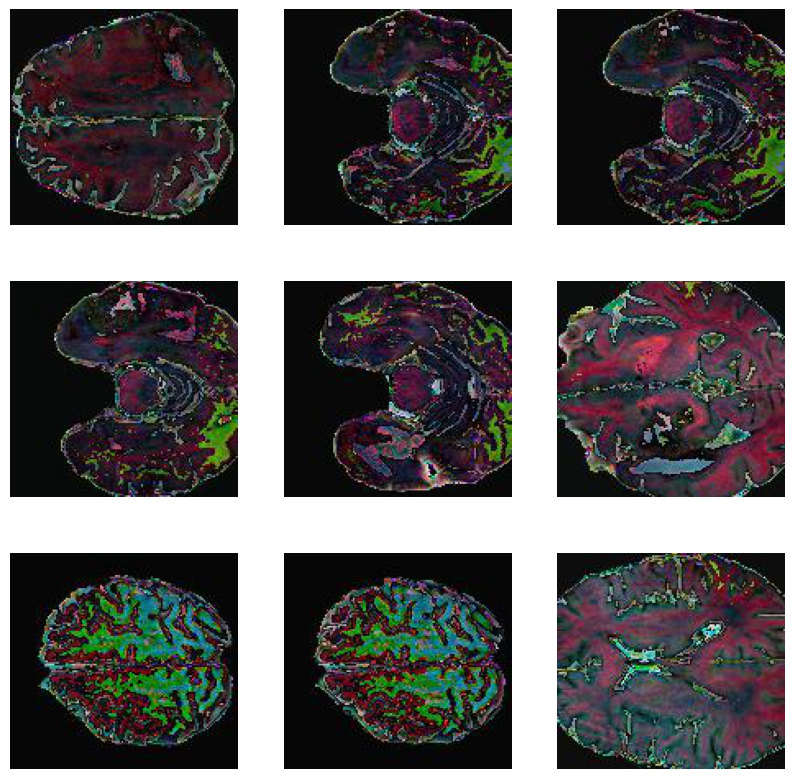

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import os
Path = "test/images"

files = [f for f in os.listdir(Path)  if os.path.isfile(os.path.join(Path, f))]
files.sort()
img_to_display = files[:9]
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    img_path = os.path.join(Path, img_to_display[i])
    img = mping.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

plt.show()

    


In [20]:
img_to_display[0]

'volume_100_slice_105_jpg.rf.cdacd3f7e2631df9516f8f0283ac430c.jpg'